In [229]:
import matplotlib.pyplot as plt
import pandas as pd
import random as rand

# V.1 Exploring the green reds

## a) Write a function that will plot a scatterplot matrix of your red wine data.

In [230]:
red = pd.read_csv("resources/winequality-red.csv", sep=';')

In [231]:
def choose_color(quality, good, bad):
    new = quality.copy()
    for idx, item in enumerate(new):
        if (item >= good):
            new[idx] = 'g'
        elif (item <= bad):
            new[idx] = 'r'
        else:
            #Make all in-between qualities transparent
            new[idx] = '#ffffff00'
    return (new)

In [232]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    color = choose_color(wine_data['quality'], good_threshold, bad_threshold)
    name = wine_data.columns
    size = len(wine_data.columns)
    fig, ax = plt.subplots(size, size, figsize = (20, 20))
    i = 0
    for row in ax:
        x = wine_data.iloc[:, i]
        i += 1
        j = 0
        for col in row:
            y = wine_data.iloc[:, j]
            j += 1
            col.axis('off')
            if (i == j):
                col.text(0.5, 0.5, name[i - 1], horizontalalignment='center', verticalalignment='center', transform=col.transAxes);
            else:
                col.scatter(x, y, c = color, marker = ".")
    if (save_plot):
        plt.savefig('plot.png')
    else:
        plt.show()

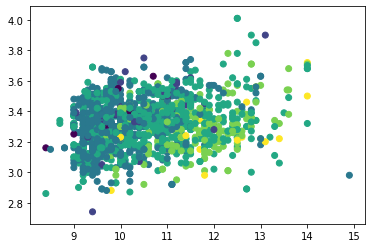

In [233]:
x = red['alcohol']
y = red['pH']
plt.scatter(x, y, c = red['quality'])
plt.show()

In [234]:
#plot_scatter_matrix(red, 8, 3)

## b) Which factors do you think will be most useful to your perceptron for distinguishing high quality vs. low quality wines? Why?

Alcohol, volatile acid and pH. <br>
Because these are the ones that feel the most separated between good and bad.

# V.2 Learning to perceptron

## a) Implement a perceptron that:
• Has randomly initialized weights and bias<br>
• Uses the Rosenblatt perceptron learning rule (with changeable learning rate)<br>
• Utilizes the heaviside step activation function (discrete version)

In [235]:
good = 8
bad = 3

In [236]:
def get_weights(data):
    weights = [rand.random() for _ in range(len(data[0]))]
    return (weights)

In [237]:
def heavyside(n):
    return (1 if n >= 0 else 0)

In [238]:
def predict(row, weights):
    # The bias is saved as the first item of the weights list
    activ = weights[0];
    for i in range(len(row) - 1):
        activ += weights[i + 1] * row[i]
    return (heavyside(activ))

The basic_train function returns the weights needed for a prediction

In [239]:
def basic_train(data, epochs = 100, learn_rate = 0.01):
    weights = get_weights(data)
    for _ in range(epochs):
        for row in data:
            prediction = predict(row, weights)
            weights[0] += learn_rate * (row[-1] - prediction)
            for i in range(len(row) -1):
                weights[i + 1] += learn_rate * (row[-1] - prediction) * row[i]
    return (weights)

## b) You’ll need to implement a function to train your perceptron. Your training functionshould take in your red wine data as a parameter and should:
• Have a way to specify number of training epochs<br>
• Train your perceptron until it makes no errors, if training epochs is set to 0,<br>
• Have a way to specify learning rate.<br>
• Return a list of python tuples containing (performance):

In [240]:
def simplify(data, good, bad):
    simple = data[['pH', 'alcohol', 'quality']]
    simple = simple[(simple.quality >= good) | (simple.quality <= bad)]
    simple['quality'] = (simple['quality'] >= good).astype(int)
    new = list(zip(simple['pH'].tolist(), simple['alcohol'].tolist(),simple['quality'].tolist()))
    return (new)

The train function returns a tuple wit the following parameters: <br>
current_epoch<br>num_errors_at_epoch_end<br>array_of_weights<br>bias

In [241]:
def train(data, epochs = 100, learn_rate = 0.01):
    weights = get_weights(data)
    performance = []
    if (epochs != 0): 
        for curr in range(epochs):
            error = 0
            for row in data:
                prediction = predict(row, weights)
                weights[0] += learn_rate * (row[-1] - prediction)
                for i in range(len(row) -1):
                    weights[i + 1] += learn_rate * (row[-1] - prediction) * row[i]
                if (prediction != row[-1]):
                    error += 1
            performance.append((curr, error, weights[1:], weights[0]))
    else:
        #If training epochs is set to 0, it goes until there are no errors
        error = 1
        curr = 0
        while (error):
            error = 0
            curr += 1
            for row in data:
                prediction = predict(row, weights)
                weights[0] += learn_rate * (row[-1] - prediction)
                for i in range(len(row) -1):
                    weights[i + 1] += learn_rate * (row[-1] - prediction) * row[i]
                if (prediction != row[-1]):
                    error += 1
            performance.append((curr, error, weights[1:], weights[0]))
    return (performance)

In [242]:
simple = simplify(red, good, bad)

In [243]:
some_errors = train(simple)
some_errors[-1]

(99, 2, [-1.0032494082278463, 0.29376777924579944], 0.10608325619654882)

In [244]:
final = train(simple, 0)
final[-1]

(13063, 0, [-7.25687297659947, 1.7307896271982388], 6.1340231688556806)

## c)Write a function that will take the output of your perceptron training function and your red wine data and generate two plots in one figure:
• The first plot should plot the number of errors your perceptron made as a function of epoch. Be careful with how you calculate errors!<br>
• The second plot should plot the decision boundary of your perceptron and also show ‘good’ and ‘bad’ wine data points on the final training epoch. This second plot should also shade ‘good’ and ‘bad’ areas!<br>
• Your function should allow the user to specify a specific epoch and see what the decision boundary of the perceptron was on that epoch. If a negative epoch is given, cause the plots to show the last epoch.

In [245]:
def plot_performance(performance, wine_data, good, bad, epoch = -1, save_plot = False):
    if (epoch < 0):
        epoch = -1
    fig, ax = plt.subplots(1, 2, figsize = (15, 15))
        
    #1st one
    plt.subplot(211)
    plt.margins(0.01)
    rot_perf = list(zip(*performance[::-1]))
    plt.bar(rot_perf[0], rot_perf[1], width = 1.0)
    plt.ylabel('errors')
    plt.xlabel('epoch')
    plt.title('Errors as a function of epoch')

    #2nd one
    plt.subplot(212)
    plt.margins(0.01)
    tup = performance[epoch]
    rot_wine = list(zip(*wine_data[::-1]))
    plt.scatter(rot_wine[1], rot_wine[0], c = rot_wine[2])

    x_min, x_max = plt.xlim()
    y = [0] * 11
    x = [0] * 11
    slope = - (tup[3] / tup[2][0]) / (tup[3] / tup[2][1])
    intercept = - tup[3] / tup[2][0]
    k = 0
    for i in range(11):
        x[i] = k + x_min
        y[i] = slope * x[i] + intercept
        k += (x_max - x_min) / 10
    plt.plot(x, y, label = 'Decision boundary')
    y_min, y_max = plt.ylim()

    plt.fill_between(x, y, y_min, facecolor = 'y', alpha = 0.2)
    plt.fill_between(x, y, y_max, facecolor = 'r', alpha = 0.2)
    
    plt.ylabel('pH')
    plt.xlabel('alcohol')
    plt.title('Decision boundary on epoch ' + str(tup[0]))

    if (save_plot):
        plt.savefig('performance.png')
    else:
        plt.show()

In [246]:
#plot_performance(final, simple, good, bad)

## d)  Your perceptron appears to work. . . but why is it taking so many epochs to train?
Maybe you can modify the red wine data to help the perceptron learn more quickly?<br>
Use the function you just created in part c) to plot and verify that your perceptron is learning more efficiently!

In [247]:
#This function scales the data to all be between 0 and 1
def mean_normal(data):
    df = data.copy()
    normalized_df=(df-df.mean())/df.std()
    return (normalized_df)

def min_max_normal(data):
    df = data.copy()
    normalized_df=(df-df.min())/(df.max()-df.min())
    return (normalized_df)

In [248]:
min_max = min_max_normal(red)
new_good = 1
new_bad = 0

In [249]:
simple = min_max[['pH', 'alcohol', 'quality']]
simple = simple[(simple.quality >= new_good) | (simple.quality <= new_bad)]
simple

,pH,alcohol,quality
267,0.480315,0.676923,1.0
278,0.385827,0.646154,1.0
390,0.645669,0.692308,1.0
440,0.110236,0.215385,1.0
455,0.377953,0.769231,1.0
459,0.401575,0.092308,0.0
481,0.322835,0.507692,1.0
495,0.322835,0.400000,1.0
498,0.322835,0.400000,1.0
517,0.330709,0.000000,0.0


In [250]:
final = train(simple, 0)
final[-1]

KeyError: 0

In [ ]:
plot_performance(final, simple, new_good, new_bad)